In [1]:
import numpy as np
import os
# os.chdir('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/')
import argparse
import utils as autils
from utils import DUST_TYPES
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib import rcParams
rcParams['font.size']=20
rcParams['axes.linewidth']=1.5
rcParams['xtick.major.width']=1.5
rcParams['xtick.minor.width']=1
rcParams['ytick.major.width']=1.5
rcParams['ytick.minor.width']=1
rcParams['xtick.major.pad']='8'
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['ytick.right'] = True
rcParams['text.usetex'] = True
rcParams['font.family'] = 'Helvetica'

%matplotlib inline

--------------------------------------------------------------------------
detected:

  Local host:            cpu-r-6
  Device name:           mlx5_0
  Device vendor ID:      0x02c9
  Device vendor part ID: 4129

Default device parameters will be used, which may result in lower
performance.  You can edit any of the files specified by the
btl_openib_device_param_files MCA parameter to set values for your
device.

NOTE: You can turn off this warning by setting the MCA parameter
      btl_openib_warn_no_device_params_found to 0.
--------------------------------------------------------------------------
--------------------------------------------------------------------------

  Local host:   cpu-r-6
  Local device: mlx5_0
--------------------------------------------------------------------------


In [2]:
args = argparse.Namespace()

args.output_dir = '/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/local_dustbias/'
# args.dust_freq = 90
args.skyfrac='GAL060'
args.mlmax=4000
# args.mask_subproduct='lensing_masks'
# args.mask_type='dr6v4_20240919'
# args.apodfact='_d2_apo3deg'
# args.daynight='night'
# args.config_name='act_dr6v4'
args.width_ra=15
args.width_dec=10

args.filter_whiteamplitude=12.
args.filter_whitefwhm=1.4
args.nsims_mf=50

# mask_options = {'apodfact': args.apodfact, 'daynight': args.daynight}
# dm = DataModel.from_config(args.config_name)

In [3]:
def args_baseline(args, skyfrac, dust_type):
    
    args.lmax=3000
    args.lmin=600
    args.dust_type=dust_type
    args.dust_freq=90.
    args.skyfrac=skyfrac
    
    return args

In [4]:
npatches = {}
submap_coord = {}
for skyfrac in autils.FSKYS:
    submap_coord[skyfrac] = np.load(args.output_dir + f'local_masks/submap_coordinates_{args.skyfrac}_{args.width_ra}_{args.width_dec}.npy')
    npatches[skyfrac] = submap_coord[skyfrac].shape[0]

In [5]:
path_recons = lambda ipatch, args, tag, mf: args.output_dir + f'stage_reconstruction/{autils.get_recons_name(ipatch, args, tag, mf)}'

In [7]:
raw_4pt = {}
rawmf_4pt = {}
n0_4pt = {}
reconstructed_cl = {}
cl_nobias = {}

for skyfrac in autils.FSKYS:
    for dust_type in autils.DUST_TYPES:
        for test in ['baseline', 'lmin', 'lmax']:
            
            raw_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
            rawmf_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
            n0_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
            cl_nobias[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]

In [11]:
autils.FSKYS

['GAL060', 'GAL070', 'GAL080']

In [13]:
TEST='baseline'

for SKYFRAC in autils.FSKYS:
    print(SKYFRAC)
    for n in range(npatches[SKYFRAC]):
        #print(n)
        for dust_type in autils.DUST_TYPES:
            raw_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'auto', mf=False))
            rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'auto', mf=True))
            n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'N0', mf=False))

for SKYFRAC in autils.FSKYS:
    print(SKYFRAC)
    for n in range(npatches[SKYFRAC]):
        for dust_type in autils.DUST_TYPES:
            cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1] - n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1]

for SKYFRAC in autils.FSKYS:
    print(SKYFRAC)
    for dust_type in autils.DUST_TYPES:
        reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)

GAL060
GAL070
GAL080
GAL060
GAL070
GAL080
GAL060
GAL070
GAL080


/tmp/ipykernel_2993314/1521373169.py:21: RuntimeWarning: Mean of empty slice
  reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)


In [14]:
ell_arr = np.arange(args.mlmax+1)
lfac =  (ell_arr * (ell_arr + 1))**2 / (2 * np.pi)

In [15]:
def plot_recons(test, ni=10):
    
    for n in range(ni):
        print(n)
        
        fig, ax = plt.subplots(1, 1, figsize=(4,3))
        ax.loglog(ell_arr[2:], (raw_4pt[test][n][:args.mlmax+1]*lfac)[2:], color='tab:blue', linestyle='dashed', linewidth = 3, label='raw cl')
        ax.loglog(ell_arr[2:], (n0_4pt[test][n][:args.mlmax+1]*lfac)[2:], linestyle = 'dashed', color ='r', linewidth = 3, label='analytic N0')
        ax.loglog(ell_arr[2:], (rawmf_4pt[test][n][:args.mlmax+1]*lfac)[2:], color='tab:green', linestyle='dashed', linewidth = 3, label='mf sub cl')

        plt.show()

0


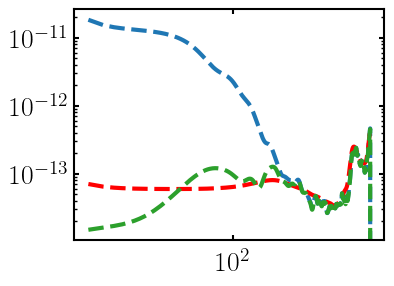

1


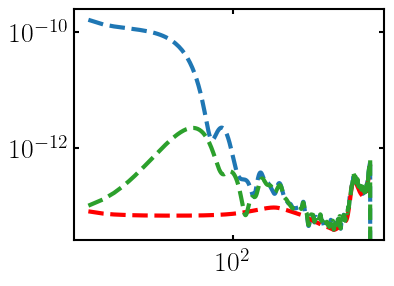

2


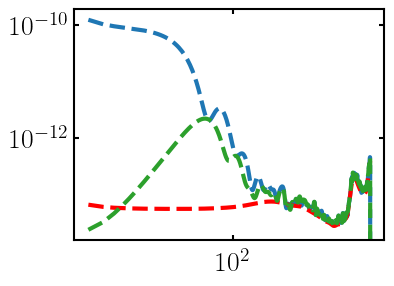

3


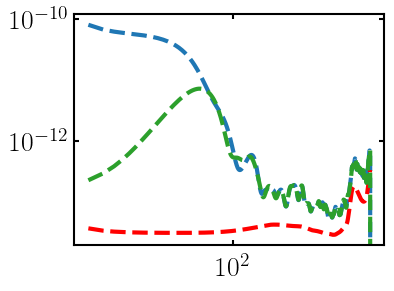

4


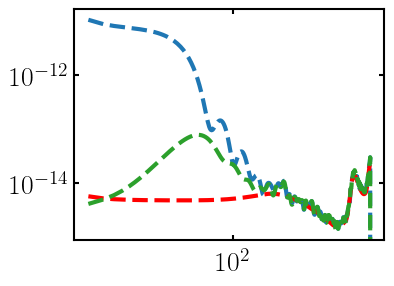

5


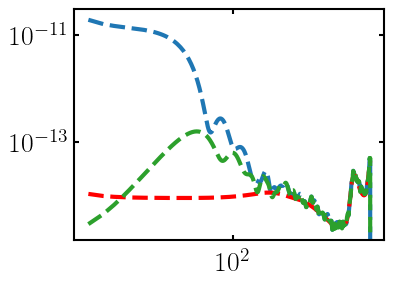

6


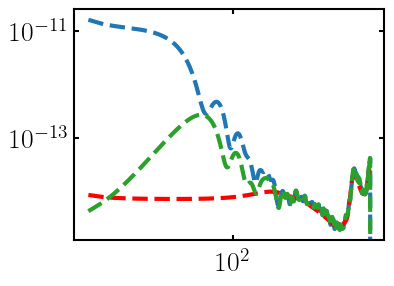

7


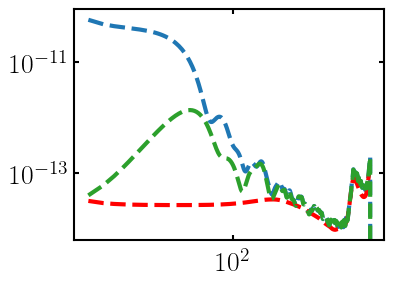

8


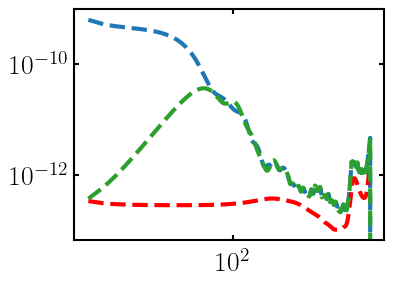

9


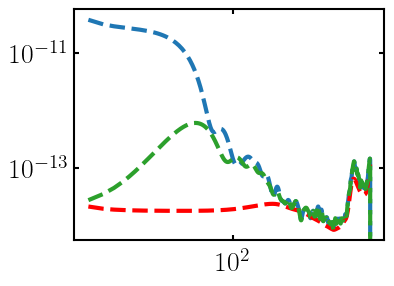

In [16]:
plot_recons('d12_GAL060_baseline')

0


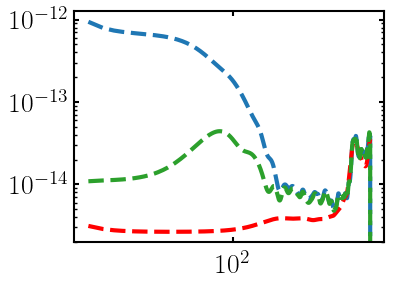

1


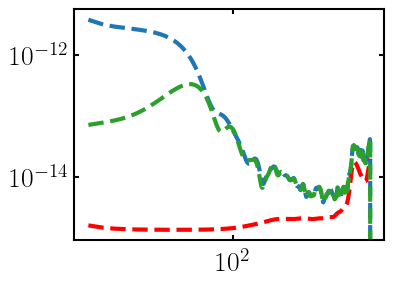

2


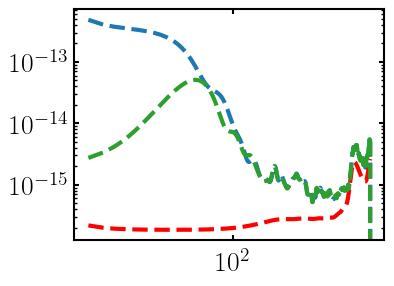

3


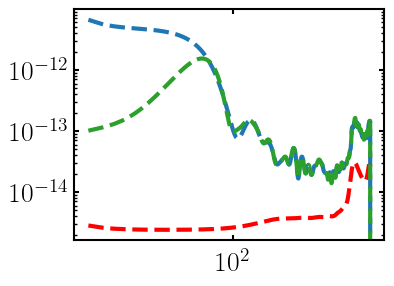

4


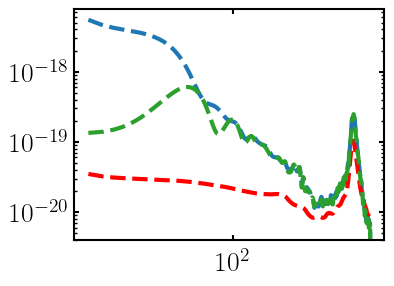

5


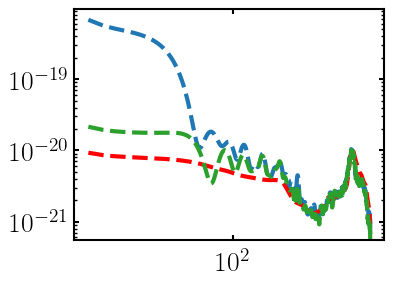

6


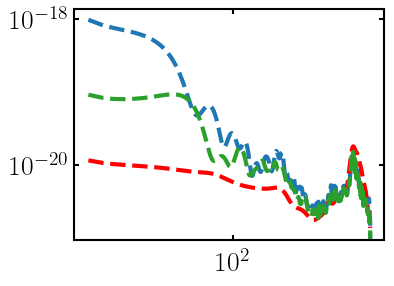

7


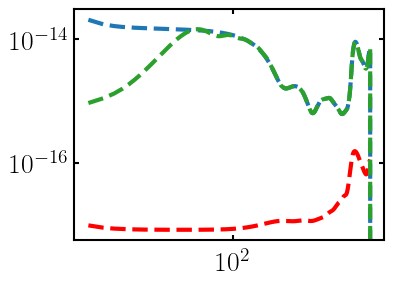

8


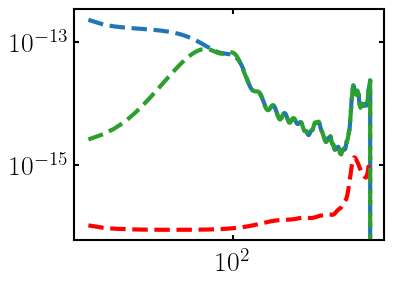

9


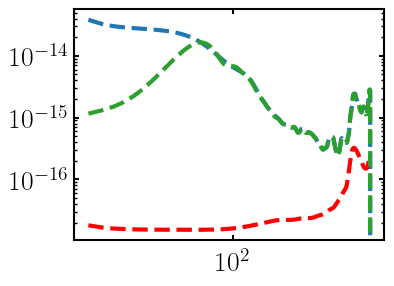

In [17]:
plot_recons('van_GAL060_baseline')

0


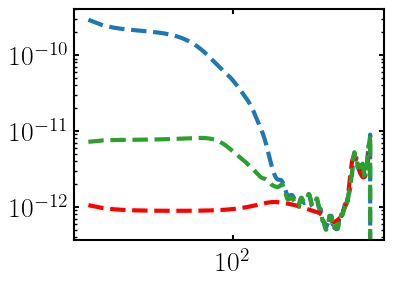

1


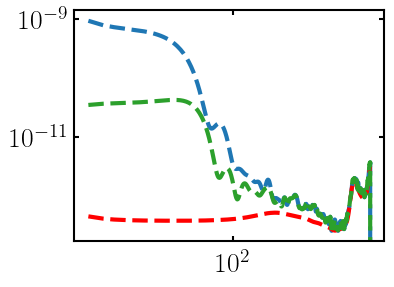

2


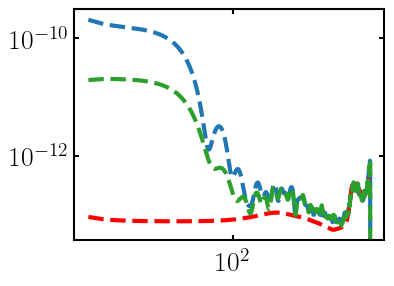

3


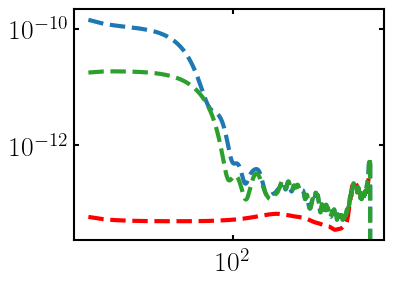

4


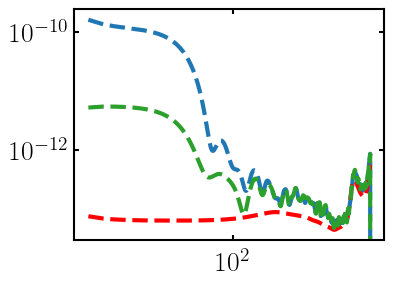

5


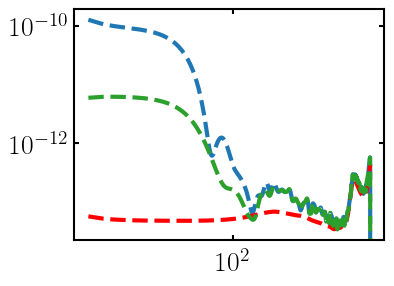

6


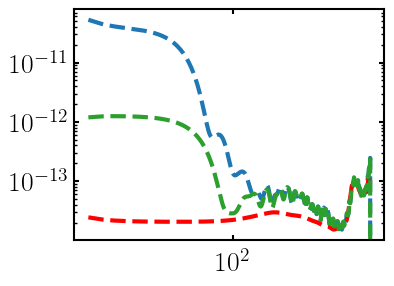

7


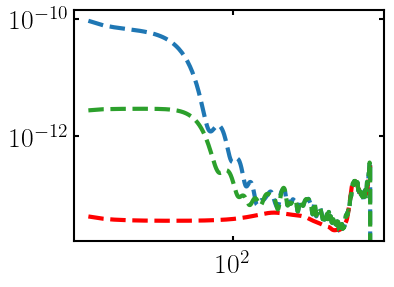

8


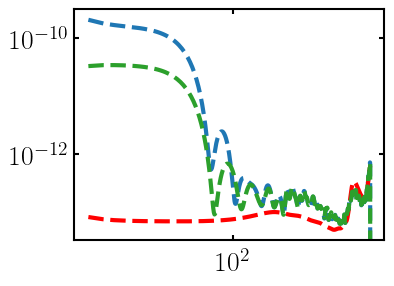

9


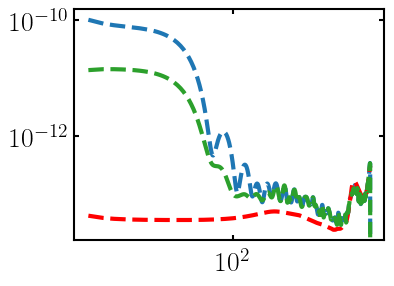

In [18]:
plot_recons('DF_GAL060_baseline')

0


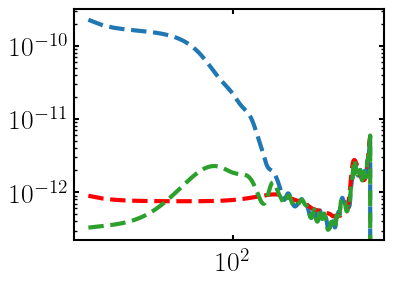

1


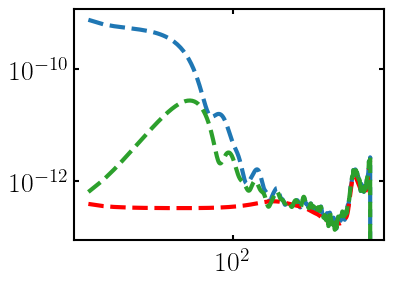

2


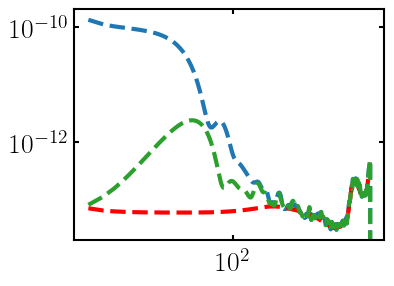

3


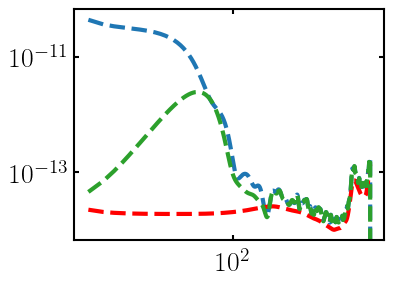

4


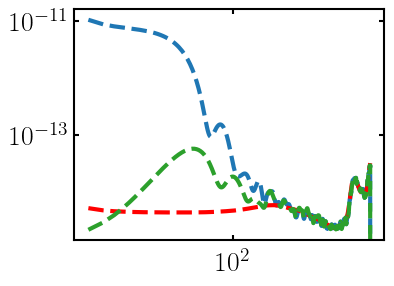

5


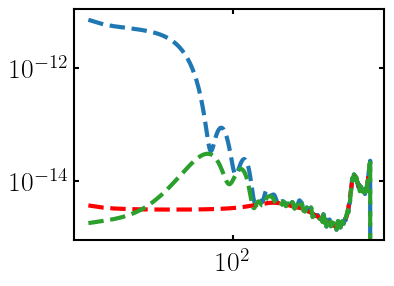

6


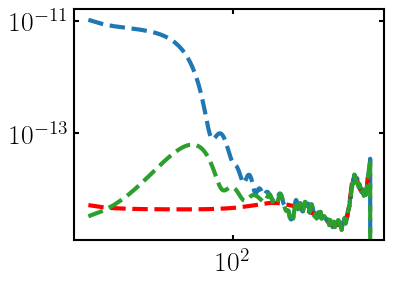

7


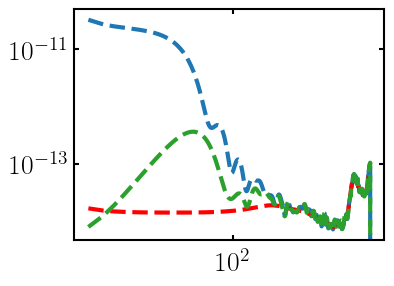

8


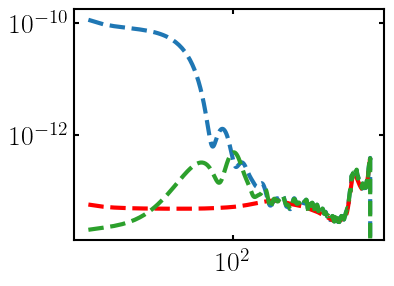

9


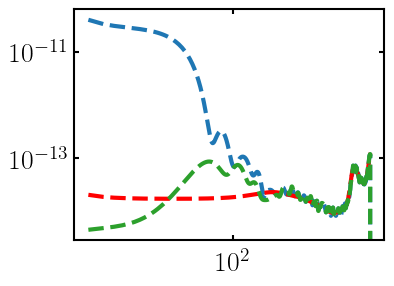

In [19]:
plot_recons('d10_GAL060_baseline')

In [77]:
def plot_recons_grid(test, istart=0, ni=6):
    
    fig, ax = plt.subplots(3,2, sharex=True, sharey=False, figsize=(6,6), dpi=200)
    ax = ax.flatten()
    for i in range(ni):
        n=istart+i
        
        #print(n)
        
        
        ax[i].loglog(ell_arr[2:], (raw_4pt[test][n][:args.mlmax+1]*lfac)[2:], color='tab:blue', linestyle='dashed', linewidth = 3, label='raw cl')
        ax[i].loglog(ell_arr[2:], (n0_4pt[test][n][:args.mlmax+1]*lfac)[2:], linestyle = 'dashed', color ='r', linewidth = 3, label='analytic N0')
        ax[i].loglog(ell_arr[2:], (rawmf_4pt[test][n][:args.mlmax+1]*lfac)[2:], color='tab:green', linestyle='dashed', linewidth = 3, label='mf sub cl')
        # ax[i].set_title(i)
    for i in [-2, -1]:
        ax[i].set_xlabel(r'$L$')
    
    fig.subplots_adjust(wspace=0.4)
    fig.suptitle(test.split('_')[0])
    fig.savefig(f'./Figures/recons_grid_{test}.png', bbox_inches='tight')
    plt.show()

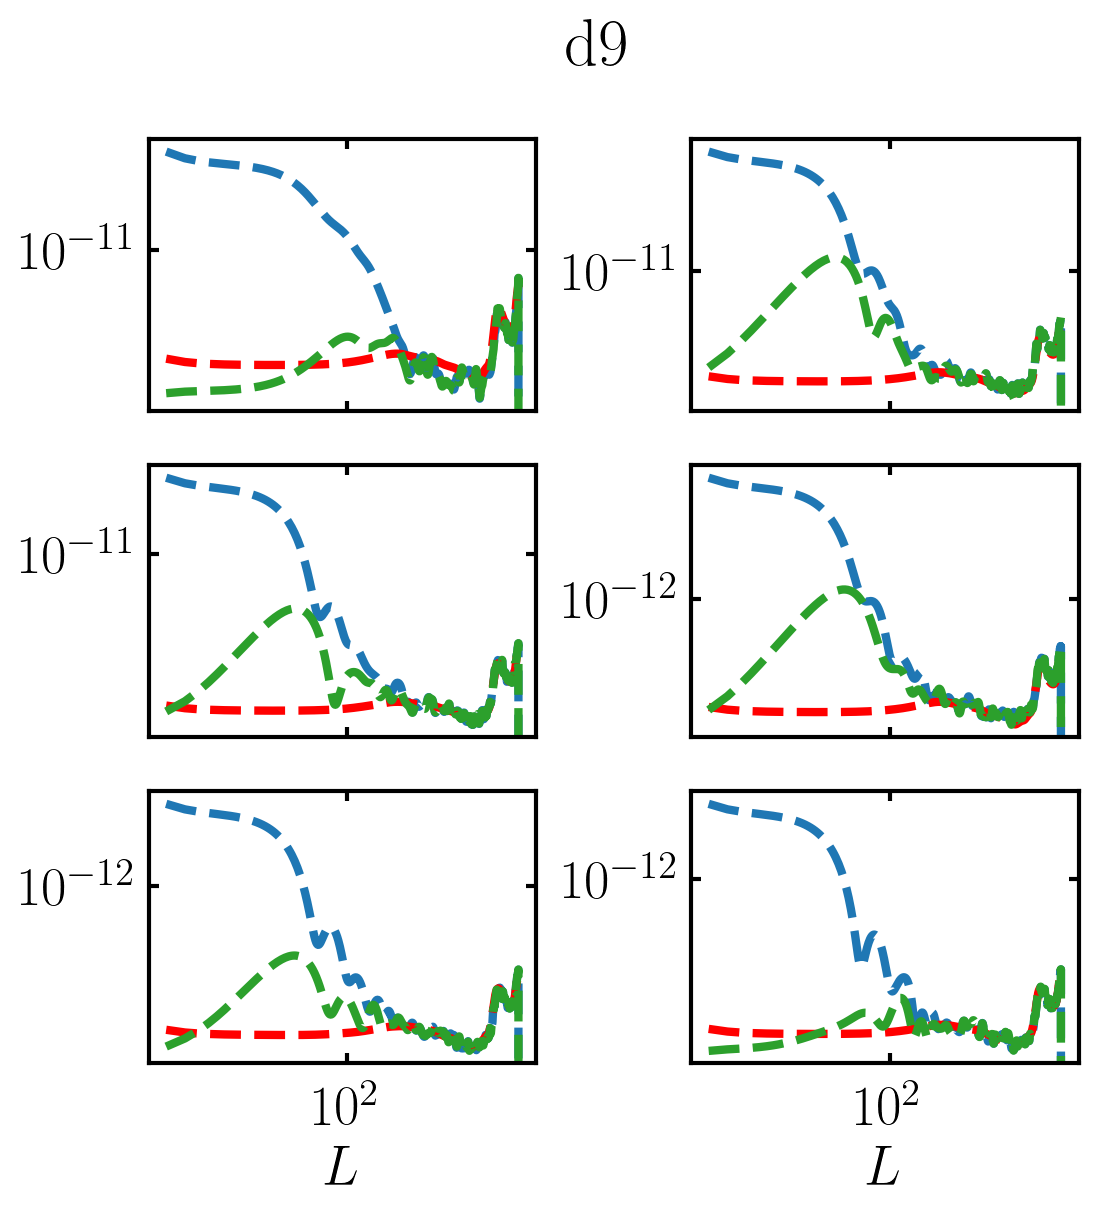

In [78]:
plot_recons_grid('d9_GAL060_baseline')

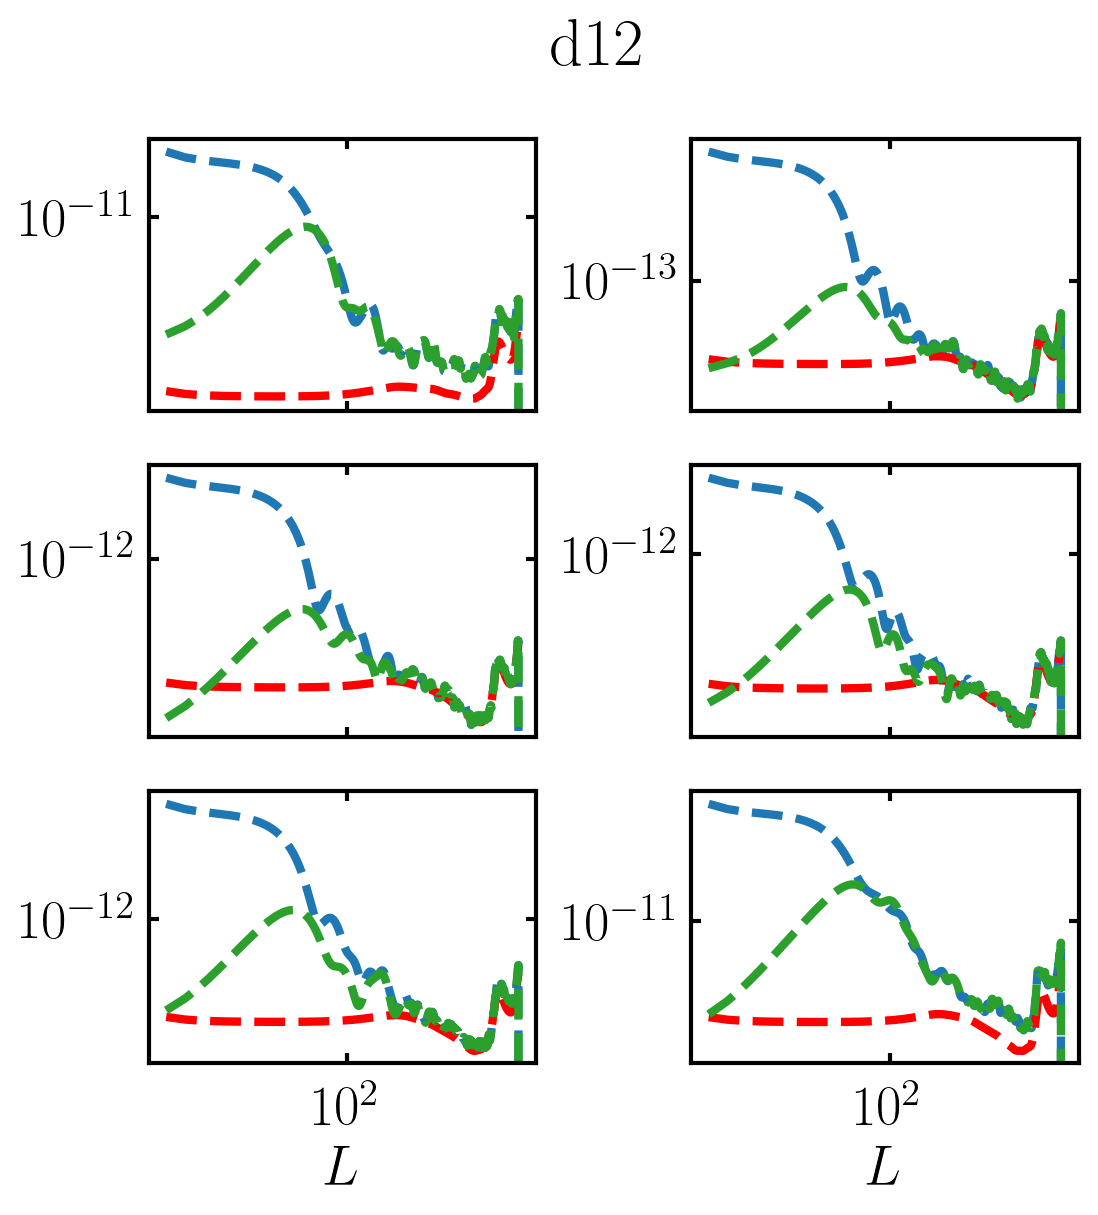

In [79]:
plot_recons_grid('d12_GAL060_baseline', istart=3)